In [17]:
import matplotlib.pyplot as plt
import arviz as az
from pystan import StanModel
import numpy as np
import pandas as pd
import seaborn as sns

In [18]:
df = pd.read_csv("../all_data/linearRegression_crimePunishment.csv")
df

,Unnamed: 0,year,stateName,murder,car,law,state
0,1,1960,Connecticut,0.470004,4.865224,1,1
1,2,1961,Connecticut,0.000000,4.873669,1,1
2,3,1962,Connecticut,0.262364,4.984976,1,1
3,4,1963,Connecticut,0.587787,5.214392,1,1
4,5,1964,Connecticut,0.587787,5.331268,1,1
...,...,...,...,...,...,...,...
535,536,2009,West Virginia,1.526056,5.020586,0,10
536,537,2010,West Virginia,1.131402,4.870607,0,10
537,538,2011,West Virginia,1.547563,4.732684,0,10
538,539,2012,West Virginia,1.335001,4.789989,0,10


<AxesSubplot:xlabel='year', ylabel='murder'>

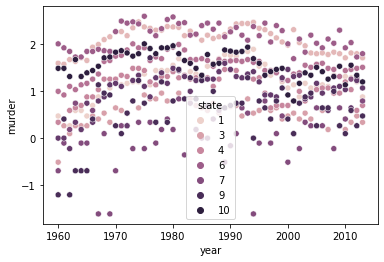

In [19]:
sns.scatterplot(x="year",y="murder",hue="state",data=df)

<AxesSubplot:xlabel='year', ylabel='car'>

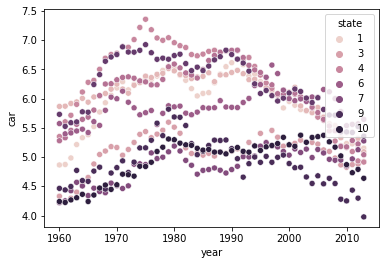

In [20]:
sns.scatterplot(x="year",y="car",hue="state",data=df)

In [21]:
model_code = """
    data{
        int N;
        int K;
        real murder[N];
        real car[N];
        int<lower=0, upper=1> law[N];
        int state[N];
    }
    parameters{
        real alpha;
        real beta;
        real gamma;
        real<lower=0> sigma;
    }
    model{
        for(i in 1:N)
            murder[i] ~ normal(alpha + beta * law[i] + gamma * car[i], sigma);
            
        alpha ~ normal(0, 1);
        beta ~ normal(0, 1);
        gamma ~ normal(0, 1);
        sigma ~ normal(0, 1);
    }
    generated quantities{
        real logLikelihood[N];
        for(i in 1:N)
            logLikelihood[i] = normal_lpdf(murder[i] | alpha + beta * law[i] +
                        gamma * car[i], sigma);
    }    
"""

In [22]:
sm = StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b7e9c5ce5336aedf374f6702722ebdfc NOW.


In [23]:
fit = sm.sampling(
    data=dict(
        N=len(df["murder"]),
        K=len(np.unique(df["state"].values)),
        murder=df["murder"].values,
        car=df["car"].values,
        law=df["law"].values,
        state=df["state"].values,
    ),
    warmup=500,
    iter=3000,
    chains=4,
)

In [24]:
print(fit)

Inference for Stan model: anon_model_b7e9c5ce5336aedf374f6702722ebdfc.
4 chains, each with iter=3000; warmup=500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha               -1.47  3.4e-3   0.22   -1.9  -1.62  -1.47  -1.33  -1.04   4012    1.0
beta                 0.24  8.9e-4   0.06   0.12    0.2   0.24   0.28   0.36   4557    1.0
gamma                0.45  6.6e-4   0.04   0.37   0.42   0.45   0.48   0.53   3852    1.0
sigma                0.62  2.6e-4   0.02   0.59   0.61   0.62   0.64   0.66   5291    1.0
logLikelihood[1]    -0.76  1.2e-3   0.08  -0.92  -0.81  -0.75   -0.7  -0.62   4133    1.0
logLikelihood[2]    -1.64  2.4e-3   0.15  -1.95  -1.74  -1.64  -1.54  -1.36   4091    1.0
logLikelihood[3]    -1.17  1.7e-3   0.11   -1.4  -1.24  -1.17   -1.1  -0.98   4164    1.0
logLikelihood[4]    -0.81 10.0e-4   0.07  -0.95  -0.85   -0.8  -0.76  -0.68   4527    1.0
l

In [37]:
model_het = """
    data{
        int N;
        int K;
        real murder[N];
        real car[N];
        int<lower=0, upper=1> law[N];
        int state[N];
    }
    parameters{
        real alpha[K];
        real beta[K];
        real gamma[K];
        real<lower=0> sigma[K];
        real alpha_top;
        real<lower=0> alpha_sigma;
        real beta_top;
        real<lower=0> beta_sigma;
        real gamma_top;
        real<lower=0> gamma_sigma;
    }
    model{
        for(i in 1:N)
            murder[i] ~ normal(alpha[state[i]] + beta[state[i]] * law[i] 
                                + gamma[state[i]] * car[i], sigma[state[i]]);
            
        alpha ~ normal(alpha_top, alpha_sigma);
        beta ~ normal(beta_top, beta_sigma);
        gamma ~ normal(gamma_top, gamma_sigma);
        alpha_top ~ normal(0, 1);
        beta_top ~ normal(0, 1);
        gamma_top ~ normal(0, 1);
        alpha_sigma ~ normal(0, 1);
        beta_sigma ~ normal(0, 1);
        gamma_sigma ~ normal(0, 1);
        sigma ~ normal(0, 1);
    }
    generated quantities{
        real alpha_average;
        real beta_average;
        real gamma_average;
        real logLikelihood[N];
        
        alpha_average = normal_rng(alpha_top, alpha_sigma);
        beta_average = normal_rng(beta_top, beta_sigma);
        gamma_average = normal_rng(gamma_top, gamma_sigma);
        
        for(i in 1:N)
            logLikelihood[i] = normal_lpdf(murder[i] | alpha[state[i]] + beta[state[i]] * law[i] +
                                            gamma[state[i]] * car[i], sigma);
    }
"""

In [38]:
sm_het = StanModel(model_code=model_het)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f8bd140bb99f7e3301875a9d395ceb5a NOW.


In [39]:
fit_het = sm_het.sampling(
    data=dict(
        N=len(df["murder"]),
        K=len(np.unique(df["state"].values)),
        murder=df["murder"].values,
        car=df["car"].values,
        law=df["law"].values,
        state=df["state"].values,
    ),
    warmup=500,
    iter=3000,
    chains=4,
)

In [40]:
print(fit_het)

Inference for Stan model: anon_model_f8bd140bb99f7e3301875a9d395ceb5a.
4 chains, each with iter=3000; warmup=500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                     mean se_mean     sd   2.5%     25%     50%    75%   97.5%  n_eff   Rhat
alpha[1]            -2.17  5.9e-3   0.38  -2.92   -2.42   -2.16  -1.91   -1.43   4216    1.0
alpha[2]            -1.62  6.0e-3   0.38  -2.37   -1.88   -1.62  -1.38   -0.89   3899    1.0
alpha[3]            -1.85  6.8e-3   0.45  -2.77   -2.14   -1.85  -1.56   -0.95   4450    1.0
alpha[4]            -1.35  3.9e-3   0.27  -1.87   -1.53   -1.35  -1.17   -0.81   4787    1.0
alpha[5]            -1.13  4.0e-3    0.3  -1.73   -1.33   -1.13  -0.93   -0.54   5633    1.0
alpha[6]            -0.59  8.5e-3   0.53  -1.59   -0.94   -0.61  -0.25    0.54   3962    1.0
alpha[7]            -1.84  9.7e-3   0.62  -3.05   -2.24   -1.87  -1.46   -0.53   4164    1.0
alpha[8]            -2.11  6.1e-3   0.43  -2.97   -2.38    -2.1  -1

In [13]:
model_time = """
    data{
        int N;
        int K;
        real murder[N];
        real car[N];
        int<lower=0, upper=1> law[N];
        int state[N];
        int time[N];
    }
    parameters{
        real alpha[K];
        real beta[K];
        real gamma[K];
        real delta[K];
        real<lower=0> sigma[K];
        real alpha_top;
        real<lower=0> alpha_sigma;
        real beta_top;
        real<lower=0> beta_sigma;
        real gamma_top;
        real<lower=0> gamma_sigma;
        real delta_top;
        real<lower=0> delta_sigma;
    }
    model{
        for(i in 1:N)
            murder[i] ~ normal(alpha[state[i]] + delta[state[i]] * time[i] + beta[state[i]] * law[i] 
                                + gamma[state[i]] * car[i], sigma[state[i]]);
            
        alpha ~ normal(alpha_top, alpha_sigma);
        beta ~ normal(beta_top, beta_sigma);
        gamma ~ normal(gamma_top, gamma_sigma);
        delta ~ normal(delta_top, delta_sigma);
        alpha_top ~ normal(0, 1);
        beta_top ~ normal(0, 1);
        gamma_top ~ normal(0, 1);
        delta_top ~ normal(0,1);
        alpha_sigma ~ normal(0, 1);
        beta_sigma ~ normal(0, 1);
        gamma_sigma ~ normal(0, 1);
        delta_sigma ~ normal(0,1);
        sigma ~ normal(0, 1);
    }
    generated quantities{
        real alpha_average;
        real beta_average;
        real gamma_average;
        real delta_average;
        
        alpha_average = normal_rng(alpha_top, alpha_sigma);
        beta_average = normal_rng(beta_top, beta_sigma);
        gamma_average = normal_rng(gamma_top, gamma_sigma);
        delta_average = normal_rng(delta_top, delta_sigma);
    }
"""

In [14]:
sm_time = StanModel(model_code=model_time)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9bbdfb051c5c6950157c16538530d0d3 NOW.


In [15]:
fit_time = sm_time.sampling(
    data=dict(
        N=len(df["murder"]),
        K=len(np.unique(df["state"].values)),
        murder=df["murder"].values,
        car=df["car"].values,
        law=df["law"].values,
        state=df["state"].values,
        time=df["year"].values,
    ),
    warmup=500,
    iter=3000,
    chains=4,
)

In [16]:
print(fit_time)

Inference for Stan model: anon_model_9bbdfb051c5c6950157c16538530d0d3.
4 chains, each with iter=3000; warmup=500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                 mean se_mean     sd    2.5%     25%     50%     75%  97.5%  n_eff   Rhat
alpha[1]        -1.43    0.66   1.51   -4.87   -2.16   -1.33   -0.32   0.79      5   1.43
alpha[2]        -1.05    0.54   1.27   -3.95   -1.72   -0.84   -0.16   0.75      6   1.38
alpha[3]        -0.48    0.35   1.09   -2.84   -1.11   -0.41    0.17   1.47     10    1.4
alpha[4]        -0.45    0.49   1.23    -3.2   -1.18   -0.31    0.47   1.45      6   1.34
alpha[5]        -0.05     0.4   1.06   -2.68   -0.51    0.11    0.59   1.66      7   1.43
alpha[6]         0.39     0.3   1.04   -2.07   -0.11    0.45    1.08   2.17     12   1.23
alpha[7]        -0.58    0.54   1.18   -3.42   -1.24   -0.37    0.37   1.04      5   1.53
alpha[8]        -0.94     0.6   1.36   -4.06   -1.68   -0.81    0.06   1.24      5   1.43
a

In [33]:
loo, _, _ = psisloo(fit.extract("logLikelihood")["logLikelihood"])
loo

-512.6847417202089

In [42]:
loo, _, _ = psisloo(fit_het.extract("logLikelihood")["logLikelihood"])
loo

<ipython-input-31-8119c469df21>:207: RuntimeWarning: overflow encountered in exp
  np.exp(temp, out=temp)


-8573.09788213537

In [46]:
np.shape(fit_het.extract("logLikelihood")["logLikelihood"])

(10000, 540)

not working for het model for some reason

In [31]:
def psisloo(log_lik, **kwargs):
    r"""PSIS leave-one-out log predictive densities.
    Computes the log predictive densities given posterior samples of the log
    likelihood terms :math:`p(y_i|\theta^s)` in input parameter `log_lik`.
    Returns a sum of the leave-one-out log predictive densities `loo`,
    individual leave-one-out log predictive density terms `loos` and an estimate
    of Pareto tail indeces `ks`. The estimates are unreliable if tail index
    ``k > 0.7`` (see more in the references listed in the module docstring).
    Additional keyword arguments are passed to the :meth:`psislw()` function
    (see the corresponding documentation).
    Parameters
    ----------
    log_lik : ndarray
        Array of size n x m containing n posterior samples of the log likelihood
        terms :math:`p(y_i|\theta^s)`.
    Returns
    -------
    loo : scalar
        sum of the leave-one-out log predictive densities
    loos : ndarray
        individual leave-one-out log predictive density terms
    ks : ndarray
        estimated Pareto tail indeces
    """
    # ensure overwrite flag in passed arguments
    kwargs['overwrite_lw'] = True
    # log raw weights from log_lik
    lw = -log_lik
    # compute Pareto smoothed log weights given raw log weights
    lw, ks = psislw(lw, **kwargs)
    # compute
    lw += log_lik
    loos = sumlogs(lw, axis=0)
    loo = loos.sum()
    return loo, loos, ks


def psislw(lw, Reff=1.0, overwrite_lw=False):
    """Pareto smoothed importance sampling (PSIS).
    Parameters
    ----------
    lw : ndarray
        Array of size n x m containing m sets of n log weights. It is also
        possible to provide one dimensional array of length n.
    Reff : scalar, optional
        relative MCMC efficiency ``N_eff / N``
    overwrite_lw : bool, optional
        If True, the input array `lw` is smoothed in-place, assuming the array
        is F-contiguous. By default, a new array is allocated.
    Returns
    -------
    lw_out : ndarray
        smoothed log weights
    kss : ndarray
        Pareto tail indices
    """
    if lw.ndim == 2:
        n, m = lw.shape
    elif lw.ndim == 1:
        n = len(lw)
        m = 1
    else:
        raise ValueError("Argument `lw` must be 1 or 2 dimensional.")
    if n <= 1:
        raise ValueError("More than one log-weight needed.")

    if overwrite_lw and lw.flags.f_contiguous:
        # in-place operation
        lw_out = lw
    else:
        # allocate new array for output
        lw_out = np.copy(lw, order='F')

    # allocate output array for kss
    kss = np.empty(m)

    # precalculate constants
    cutoff_ind = - int(np.ceil(min(0.2 * n, 3 * np.sqrt(n / Reff)))) - 1
    cutoffmin = np.log(np.finfo(float).tiny)
    logn = np.log(n)
    k_min = 1/3

    # loop over sets of log weights
    for i, x in enumerate(lw_out.T if lw_out.ndim == 2 else lw_out[None, :]):
        # improve numerical accuracy
        x -= np.max(x)
        # sort the array
        x_sort_ind = np.argsort(x)
        # divide log weights into body and right tail
        xcutoff = max(
            x[x_sort_ind[cutoff_ind]],
            cutoffmin
        )
        expxcutoff = np.exp(xcutoff)
        tailinds, = np.where(x > xcutoff)
        x2 = x[tailinds]
        n2 = len(x2)
        if n2 <= 4:
            # not enough tail samples for gpdfitnew
            k = np.inf
        else:
            # order of tail samples
            x2si = np.argsort(x2)
            # fit generalized Pareto distribution to the right tail samples
            np.exp(x2, out=x2)
            x2 -= expxcutoff
            k, sigma = gpdfitnew(x2, sort=x2si)
        if k >= k_min and not np.isinf(k):
            # no smoothing if short tail or GPD fit failed
            # compute ordered statistic for the fit
            sti = np.arange(0.5, n2)
            sti /= n2
            qq = gpinv(sti, k, sigma)
            qq += expxcutoff
            np.log(qq, out=qq)
            # place the smoothed tail into the output array
            x[tailinds[x2si]] = qq
            # truncate smoothed values to the largest raw weight 0
            x[x > 0] = 0
        # renormalize weights
        x -= sumlogs(x)
        # store tail index k
        kss[i] = k

    # If the provided input array is one dimensional, return kss as scalar.
    if lw_out.ndim == 1:
        kss = kss[0]

    return lw_out, kss


def gpdfitnew(x, sort=True, sort_in_place=False, return_quadrature=False):
    """Estimate the paramaters for the Generalized Pareto Distribution (GPD)
    Returns empirical Bayes estimate for the parameters of the two-parameter
    generalized Parato distribution given the data.
    Parameters
    ----------
    x : ndarray
        One dimensional data array
    sort : bool or ndarray, optional
        If known in advance, one can provide an array of indices that would
        sort the input array `x`. If the input array is already sorted, provide
        False. If True (default behaviour), the array is sorted internally.
    sort_in_place : bool, optional
        If `sort` is True and `sort_in_place` is True, the array is sorted
        in-place (False by default).
    return_quadrature : bool, optional
        If True, quadrature points and weight `ks` and `w` of the marginal posterior distribution of k are also calculated and returned. False by
        default.
    Returns
    -------
    k, sigma : float
        estimated parameter values
    ks, w : ndarray
        Quadrature points and weights of the marginal posterior distribution
        of `k`. Returned only if `return_quadrature` is True.
    Notes
    -----
    This function returns a negative of Zhang and Stephens's k, because it is
    more common parameterisation.
    """
    if x.ndim != 1 or len(x) <= 1:
        raise ValueError("Invalid input array.")

    # check if x should be sorted
    if sort is True:
        if sort_in_place:
            x.sort()
            xsorted = True
        else:
            sort = np.argsort(x)
            xsorted = False
    elif sort is False:
        xsorted = True
    else:
        xsorted = False

    n = len(x)
    PRIOR = 3
    m = 30 + int(np.sqrt(n))

    bs = np.arange(1, m + 1, dtype=float)
    bs -= 0.5
    np.divide(m, bs, out=bs)
    np.sqrt(bs, out=bs)
    np.subtract(1, bs, out=bs)
    if xsorted:
        bs /= PRIOR * x[int(n/4 + 0.5) - 1]
        bs += 1 / x[-1]
    else:
        bs /= PRIOR * x[sort[int(n/4 + 0.5) - 1]]
        bs += 1 / x[sort[-1]]

    ks = np.negative(bs)
    temp = ks[:,None] * x
    np.log1p(temp, out=temp)
    np.mean(temp, axis=1, out=ks)

    L = bs / ks
    np.negative(L, out=L)
    np.log(L, out=L)
    L -= ks
    L -= 1
    L *= n

    temp = L - L[:,None]
    np.exp(temp, out=temp)
    w = np.sum(temp, axis=1)
    np.divide(1, w, out=w)

    # remove negligible weights
    dii = w >= 10 * np.finfo(float).eps
    if not np.all(dii):
        w = w[dii]
        bs = bs[dii]
    # normalise w
    w /= w.sum()

    # posterior mean for b
    b = np.sum(bs * w)
    # Estimate for k, note that we return a negative of Zhang and
    # Stephens's k, because it is more common parameterisation.
    temp = (-b) * x
    np.log1p(temp, out=temp)
    k = np.mean(temp)
    if return_quadrature:
        np.negative(x, out=temp)
        temp = bs[:, None] * temp
        np.log1p(temp, out=temp)
        ks = np.mean(temp, axis=1)
    # estimate for sigma
    sigma = -k / b * n / (n - 0)
    # weakly informative prior for k
    a = 10
    k = k * n / (n+a) + a * 0.5 / (n+a)
    if return_quadrature:
        ks *= n / (n+a)
        ks += a * 0.5 / (n+a)

    if return_quadrature:
        return k, sigma, ks, w
    else:
        return k, sigma


def gpinv(p, k, sigma):
    """Inverse Generalised Pareto distribution function."""
    x = np.empty(p.shape)
    x.fill(np.nan)
    if sigma <= 0:
        return x
    ok = (p > 0) & (p < 1)
    if np.all(ok):
        if np.abs(k) < np.finfo(float).eps:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            np.negative(x, out=x)
        else:
            np.negative(p, out=x)
            np.log1p(x, out=x)
            x *= -k
            np.expm1(x, out=x)
            x /= k
        x *= sigma
    else:
        if np.abs(k) < np.finfo(float).eps:
            # x[ok] = - np.log1p(-p[ok])
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            np.negative(temp, out=temp)
            x[ok] = temp
        else:
            # x[ok] = np.expm1(-k * np.log1p(-p[ok])) / k
            temp = p[ok]
            np.negative(temp, out=temp)
            np.log1p(temp, out=temp)
            temp *= -k
            np.expm1(temp, out=temp)
            temp /= k
            x[ok] = temp
        x *= sigma
        x[p == 0] = 0
        if k >= 0:
            x[p == 1] = np.inf
        else:
            x[p == 1] = -sigma / k
    return x


def sumlogs(x, axis=None, out=None):
    """Sum of vector where numbers are represented by their logarithms.
    Calculates ``np.log(np.sum(np.exp(x), axis=axis))`` in such a fashion that
    it works even when elements have large magnitude.
    """
    maxx = x.max(axis=axis, keepdims=True)
    xnorm = x - maxx
    np.exp(xnorm, out=xnorm)
    out = np.sum(xnorm, axis=axis, out=out)
    if isinstance(out, np.ndarray):
        np.log(out, out=out)
    else:
        out = np.log(out)
    out += np.squeeze(maxx)
    return out